In [1]:
!pip install tushare

     |████████████████████████████████| 215kB 23.8MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 133kB 46.0MB/s 


In [21]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset,DataLoader
import tushare as ts

In [27]:
cons = ts.get_apis()
df = ts.bar('00001', conn=cons, asset='INDEX', start_date='2017-01-01', end_date='')

# 注意历史数据靠前
df = df.sort_index(ascending=True)
df.to_csv('sh.csv')

# 可以看出，周末不进行交易
df.head(20)

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


,code,open,close,high,low,vol,amount,p_change
datetime,,,,,,,,
2017-01-03,00001,3105.31,3135.92,3136.46,3105.31,1415671.0,1.598871e+11,NaN
2017-01-04,00001,3133.79,3158.79,3160.10,3130.11,1678608.0,1.959143e+11,0.73
2017-01-05,00001,3157.91,3165.41,3168.50,3154.28,1747276.0,1.996920e+11,0.21
2017-01-06,00001,3163.78,3154.32,3172.03,3153.03,1837089.0,2.072960e+11,-0.35
2017-01-09,00001,3148.53,3171.24,3173.14,3147.74,1717140.0,1.921106e+11,0.54
2017-01-10,00001,3167.57,3161.67,3174.58,3157.33,1797592.0,1.949632e+11,-0.30
2017-01-11,00001,3156.69,3136.75,3167.03,3136.27,1783622.0,1.891865e+11,-0.79
2017-01-12,00001,3133.60,3119.29,3144.97,3115.98,1488892.0,1.619223e+11,-0.56
2017-01-13,00001,3116.08,3112.76,3130.51,3102.16,1562742.0,1.744385e+11,-0.21


In [41]:
df = pd.read_csv('sh.csv', index_col=0)
df.index = list(map(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'), df.index))
df.head()

,code,open,close,high,low,vol,amount,p_change
2017-01-03,1,3105.31,3135.92,3136.46,3105.31,1415671.0,1.598871e+11,NaN
2017-01-04,1,3133.79,3158.79,3160.10,3130.11,1678608.0,1.959143e+11,0.73
2017-01-05,1,3157.91,3165.41,3168.50,3154.28,1747276.0,1.996920e+11,0.21
2017-01-06,1,3163.78,3154.32,3172.03,3153.03,1837089.0,2.072960e+11,-0.35
2017-01-09,1,3148.53,3171.24,3173.14,3147.74,1717140.0,1.921106e+11,0.54


In [29]:
def getData(df, column, train_end=-300, days_before=30, return_all=True, generate_index=False):
    '''
    读取原始数据，并生成训练样本
    df             : 原始数据
    column         : 要处理的列
    train_end      : 训练集的终点
    days_before    : 多少天来预测下一天
    return_all     : 是否返回所有数据，默认 True
    generate_index : 是否生成 index
    '''
    series = df[column].copy()
    
    # 划分数据
    # 0 ~ train_end 的为训练数据，但实际上，最后的 n 天只是作为 label
    # 而 train 中的 label，可用于 test
    train_series, test_series = series[:train_end], series[train_end - days_before:]
    
    # 创建训练集
    train_data = pd.DataFrame()
        
    # 通过移位，创建历史 days_before 天的数据
    for i in range(days_before):
        # 当前数据的 7 天前的数据，应该取 开始到 7 天前的数据； 昨天的数据，应该为开始到昨天的数据，如：
        # [..., 1,2,3,4,5,6,7] 昨天的为 [..., 1,2,3,4,5,6]
        # 比如从 [2:-7+2]，其长度为 len - 7
        train_data['c%d' % i] = train_series.tolist()[i: -days_before + i]
            
    # 获取对应的 label
    train_data['y'] = train_series.tolist()[days_before:]
        
    # 是否生成 index
    if generate_index:
        train_data.index = train_series.index[n:]
                
    if return_all:
        return train_data, series, df.index.tolist()
    
    return train_data

In [30]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=1,   # 输入尺寸为 1，表示一天的数据
            hidden_size=64,
            num_layers=1, 
            batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(64,1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)   # None 表示 hidden state 会用全 0 的 state
        out = self.out(r_out[:, -1, :])          # 取最后一天作为输出
        
        return out

In [31]:
class TrainSet(Dataset):
    def __init__(self, data):
        # 定义好 image 的路径
        # data 取前多少天的数据， label 取最后一天的数据
        self.data, self.label = data[:, :-1].float(), data[:, -1].float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

In [32]:
LR = 0.0001
EPOCH = 100
TRAIN_END=-300
DAYS_BEFORE=7

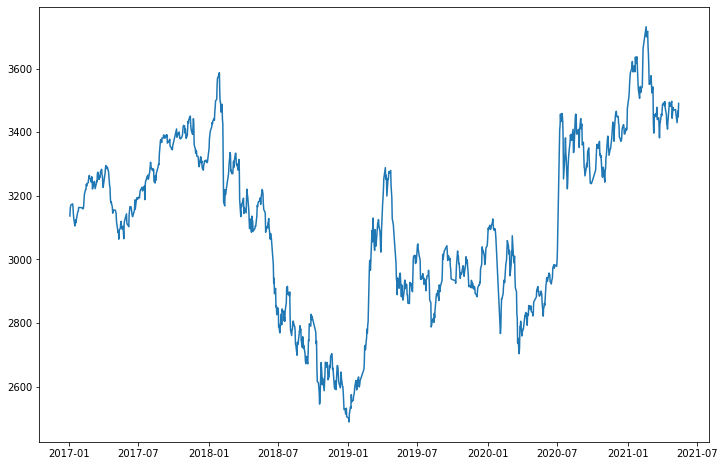

In [33]:
# 数据集建立
train_data, all_series, df_index = getData(df, 'high', days_before=DAYS_BEFORE, train_end=TRAIN_END)

# 获取所有原始数据
all_series = np.array(all_series.tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')

# 归一化，便与训练
train_data_numpy = np.array(train_data)
train_mean = np.mean(train_data_numpy)
train_std  = np.std(train_data_numpy)
train_data_numpy = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy)

# 创建 dataloader
train_set = TrainSet(train_data_tensor)
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)

In [34]:
rnn = LSTM()

if torch.cuda.is_available():
    rnn = rnn.cuda()

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.MSELoss()

for step in range(EPOCH):
    for tx, ty in train_loader:
        
        if torch.cuda.is_available():
            tx = tx.cuda()
            ty = ty.cuda()       
        
        output = rnn(torch.unsqueeze(tx, dim=2))
        loss = loss_func(torch.squeeze(output), ty)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # back propagation, compute gradients
        optimizer.step()
    print(step, loss.cpu())
    if step % 10:
        torch.save(rnn, 'rnn.pkl')
torch.save(rnn, 'rnn.pkl')

0 tensor(1.6766, grad_fn=<CopyBackwards>)
1 tensor(1.0082, grad_fn=<CopyBackwards>)
2 tensor(0.2316, grad_fn=<CopyBackwards>)
3 tensor(0.0430, grad_fn=<CopyBackwards>)
4 tensor(0.0108, grad_fn=<CopyBackwards>)
5 tensor(0.0358, grad_fn=<CopyBackwards>)
6 tensor(0.0882, grad_fn=<CopyBackwards>)
7 tensor(0.1117, grad_fn=<CopyBackwards>)
8 tensor(0.1259, grad_fn=<CopyBackwards>)
9 tensor(0.0109, grad_fn=<CopyBackwards>)
10 tensor(0.0966, grad_fn=<CopyBackwards>)
11 tensor(0.0342, grad_fn=<CopyBackwards>)
12 tensor(0.0588, grad_fn=<CopyBackwards>)
13 tensor(0.0070, grad_fn=<CopyBackwards>)
14 tensor(0.0172, grad_fn=<CopyBackwards>)
15 tensor(0.0409, grad_fn=<CopyBackwards>)
16 tensor(0.0122, grad_fn=<CopyBackwards>)
17 tensor(0.0287, grad_fn=<CopyBackwards>)
18 tensor(0.0060, grad_fn=<CopyBackwards>)
19 tensor(0.0177, grad_fn=<CopyBackwards>)
20 tensor(0.0121, grad_fn=<CopyBackwards>)
21 tensor(0.0163, grad_fn=<CopyBackwards>)
22 tensor(0.0025, grad_fn=<CopyBackwards>)
23 tensor(0.0596, gra

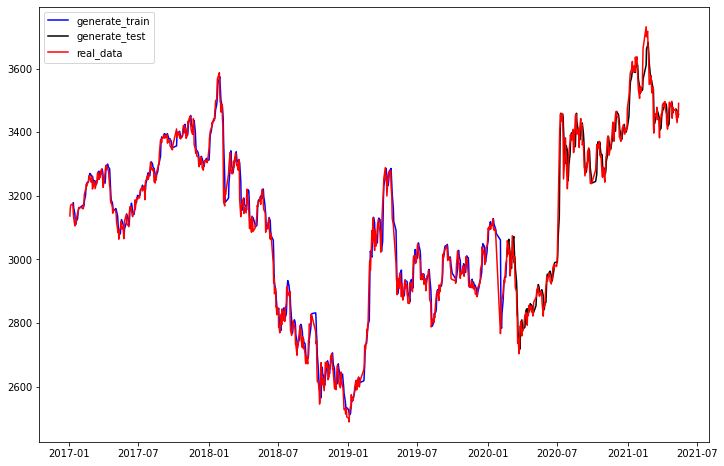

In [35]:
generate_data_train = []
generate_data_test = []

# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END

# 对所有的数据进行相同的归一化
all_series = (all_series - train_mean) / train_std
all_series = torch.Tensor(all_series)

for i in range(DAYS_BEFORE, len(all_series)):
    x = all_series[i - DAYS_BEFORE:i]
    # 将 x 填充到 (bs, ts, is) 中的 timesteps
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=2)
    
    if torch.cuda.is_available():
        x = x.cuda()

    y = rnn(x)
    
    if i < test_start:
        generate_data_train.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
    else:
        generate_data_test.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
        
plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series.clone().numpy()* train_std + train_mean, 'r', label='real_data')
plt.legend()
plt.show()

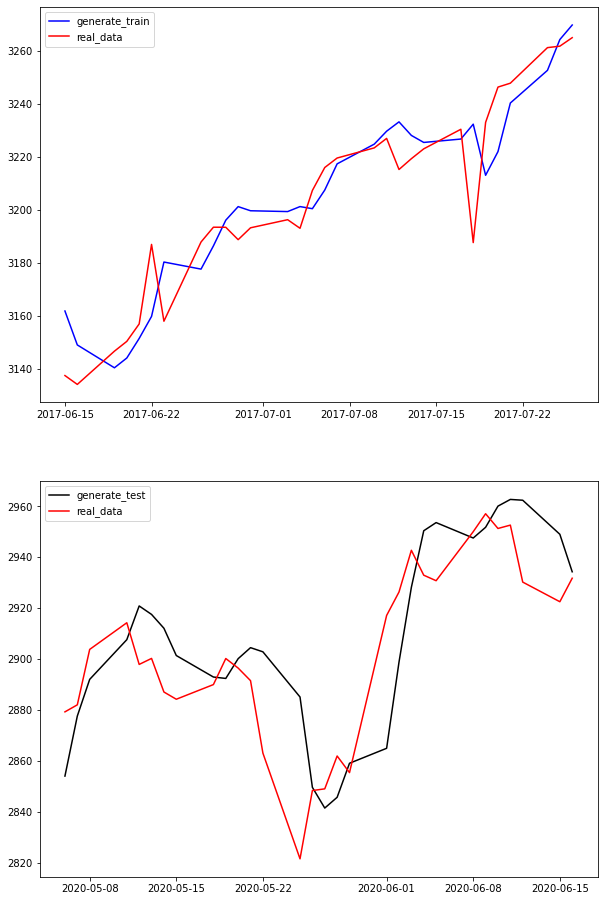

In [36]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END + 50: TRAIN_END + 80], generate_data_test[50:80], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END + 50: TRAIN_END + 80], (all_series.clone().numpy()* train_std + train_mean)[TRAIN_END + 50: TRAIN_END + 80], 'r', label='real_data')
plt.legend()

plt.show()
